In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import threading
import queue
from typing import TypeVar, Dict, Callable, Tuple, Union, List, Generic
Fn = Callable

%matplotlib inline
%load_ext line_profiler

In [2]:
Action = int
State = TypeVar('State')
c_puct: float = 10.0

def sample(it):
    rand = np.random.sample()
    t = 0.0
    if isinstance(it, dict):
        it = it.items()
    else:
        it = enumerate(it)
    for i, f in it:
        t = t + f
        if rand <= t:
            return i
        
debug = False
    
class MCTSNode(Generic[State]):
    def __init__(self, state: State, probs: np.ndarray) -> None:
        self.actions = np.flatnonzero(probs)
        self.inv_actions = np.empty_like(probs, dtype=np.int)
        self.inv_actions[self.actions] = np.arange(self.actions.size)
        
        self.N: np.ndarray = np.zeros_like(self.actions, dtype=np.int)
        self.W: np.ndarray = np.zeros_like(self.actions, dtype=np.float)
        self.Q: np.ndarray = np.zeros_like(self.actions, dtype=np.float)
        self.P: np.ndarray = probs[self.actions]
        
        self.state: State = state
        self.total_visits: int = 1
        self.children: List[MCTSNode] = [None] * probs.size
            
    def select_action(self) -> Action:
        if not self.actions.size:
            return None
        
        root_total = math.sqrt(self.total_visits)
        
        selection_priorities = self.Q + c_puct * root_total * self.P / (1 + self.N)
        if debug:
            print(self.state, selection_priorities)
        return self.actions[np.argmax(selection_priorities)]
    
    def backup(self, a, v):
        self.total_visits = self.total_visits + 1
        idx = self.inv_actions[a]
        self.N[idx] = self.N[idx] + 1
        self.W[idx] = self.W[idx] + v
        self.Q[idx] = self.W[idx] / self.N[idx]
    
    def probs(self, temp) -> np.ndarray:
        if temp == 0.0:
            ret = np.zeros_like(self.inv_actions)
            ret[self.actions[np.argmax(self.N)]] = 1.0
            return ret
        exps = self.N ** (1.0 / temp)
        ret = np.zeros_like(self.inv_actions, dtype=np.float)
        ret[self.actions] = exps / np.sum(exps)
        return ret
    
class Game(Generic[State]):
    def __init__(self,
                 gen_root: Fn[[], State],
                 do_action: Fn[[State, Action], State],
                 get_actions: Fn[[State], List[Action]],
                 end: Fn[[State], int]):
        self.gen_root = gen_root
        self.do_action = do_action
        self.get_actions = get_actions
        self.end = end
    
class MCTSPlayer(Generic[State]):
    def __init__(self,
                 game: Game[State],
                 eval_state: Fn[[State], Tuple[np.ndarray, float]]):
        self.game = game
        self.eval_state = eval_state
        
    def take_turn(self, root_node: Union[MCTSNode, State], search_size: int) -> MCTSNode:
        if not isinstance(root_node, MCTSNode):
            probs, _ = self.eval_state(root_node)
            root_node = MCTSNode(root_node)
        
        for _ in range(search_size):
            cur_node = root_node
            next_action = cur_node.select_action()
            if debug:
                print(cur_node.state, cur_node.P, next_action)
            prev = [(cur_node, next_action)]

            while next_action != None and cur_node.children[next_action] != None:
                cur_node = cur_node.children[next_action]
                next_action = cur_node.select_action()

                if next_action != None:
                    prev.append((cur_node, next_action))

            v: float
            if next_action == None:
                _, v = self.eval_state(cur_node.state)
            else:
                new_state = self.game.do_action(cur_node.state, next_action)
                probs, v = self.eval_state(new_state)
                new_node = MCTSNode(new_state, probs)
                cur_node.children[next_action] = new_node

            for i, (node, act) in enumerate(reversed(prev)):
                node.backup(act, v if i % 2 == 1 else -v)
                
        return root_node
    
    def play_self(self, search_size: int, temp: float = 0.0) -> List[Tuple[State, np.ndarray, float]]:
        root_state = self.game.gen_root()
        probs, _ = self.eval_state(root_state)
        cur_node = MCTSNode(root_state, probs)
        history: List[Tuple[State, np.ndarray]] = []
        
        while cur_node.actions.size != 0:
            self.take_turn(cur_node, search_size)
            probs = cur_node.probs(temp)
            next_act = sample(probs)
            
            history.append((cur_node.state, probs))
            
            cur_node = cur_node.children[next_act]
            
        #print(ttt_end(cur_node.state, True), cur_node.state, np.all(cur_node.state[0]))
        history.append((cur_node.state, probs))
        _, r = self.eval_state(cur_node.state)
        
        return list(reversed([(s, p, r if i % 2 == 1 else -r)
                              for i, (s, p) in enumerate(reversed(history))]))


In [3]:
TTTState = Tuple[np.ndarray, int]
ttt_board_shape = (9,)

def ttt_gen_root() -> TTTState:
    return (np.zeros(9, dtype=np.int), 1)

def ttt_do_action(s: TTTState, a: Action) -> TTTState:
    new_board = np.copy(s[0])
    cur_player = s[1]
    
    new_board[a] = cur_player
    return (new_board, -cur_player)

def ttt_get_actions(s: TTTState) -> np.ndarray:
    return np.nonzero(s[0] == 0)[0]

_end_idx = sum([[3 * i, 3 * i + 1, 3 * i + 2, i, i + 3, i + 6 ] for i in range(3)], [])
_end_idx = np.array(_end_idx + [2, 4, 6, 0, 4, 8])
_inv_end_idx = np.array(sum([[3 * i, i] for i in range(3)], []) + [2, 0])
def ttt_end(s: TTTState) -> int:
    board = s[0]
    
    z = np.flatnonzero(np.abs(np.sum(board[_end_idx].reshape(8, 3), axis=1)) == 3)
    if z.size:
        return board[_inv_end_idx[z[0]]] * s[1]

    if np.all(board):
        return 0.0
    
    return None

def ttt_eval_state(s: TTTState) -> Tuple[np.ndarray, float]:
    end = ttt_end(s)
    if end != None:
        return (np.zeros(ttt_board_shape), end)
    acts = np.zeros(ttt_board_shape)
    valid_acts = ttt_get_actions(s)
    acts[valid_acts] = 1.0 / valid_acts.size
    return (acts, 0.0)
    
ttt = Game(ttt_gen_root, ttt_do_action, ttt_get_actions, ttt_end)

Wall time: 5.59 s


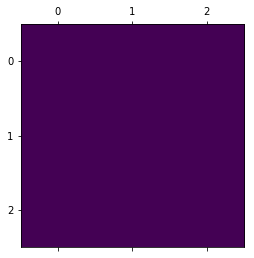

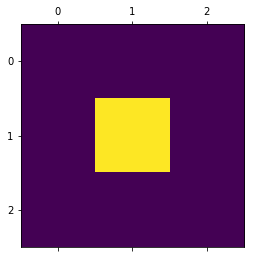

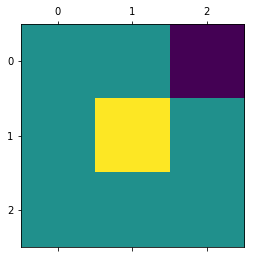

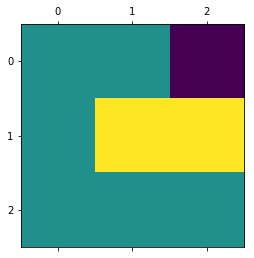

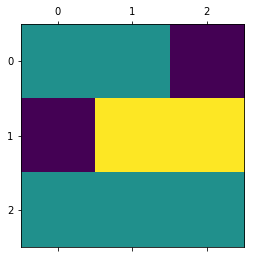

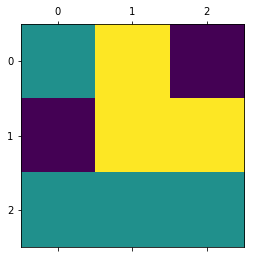

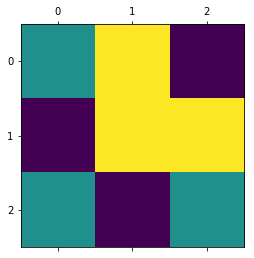

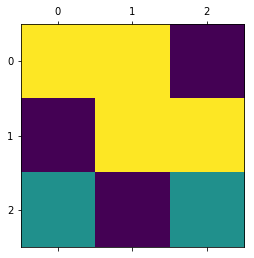

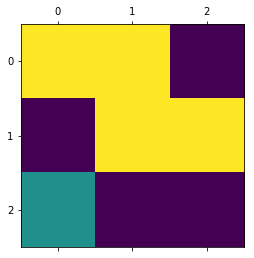

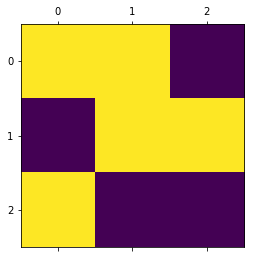

In [4]:
%%time

for s, _, _ in MCTSPlayer(ttt, ttt_eval_state).play_self(10000):
    plt.matshow(np.array(s[0]).reshape(3, 3))

In [10]:
def softmax(x):
    if len(x.shape) == 1:
        exped = np.exp(x - np.max(x))
        return exped / exped.sum()
    else:
        mx = np.max(x, axis=1)
        mx = mx.reshape((1,) + mx.shape).transpose()
        exped = np.exp(x - mx)
        denom = np.sum(exped, axis=1)
        denom = denom.reshape((1,) + denom.shape).transpose()
        return exped / denom

class ExpertIterationTrainer(Generic[State]):
    def __init__(self,
                 mk_eval_feed_dict: Fn[[List[State]], Dict[tf.Tensor, np.ndarray]],
                 mk_train_feed_dict: Fn[[List[Tuple[np.ndarray, float]]], 
                                        Dict[tf.Tensor, np.ndarray]],
                 actions: tf.Tensor,
                 value: tf.Tensor,
                 optimizer: tf.train.Optimizer,
                 graph: tf.Graph,
                 game: Game[State],
                 num_iterations: int,
                 iteration_size: int = 100,
                 search_size: int = 100):
        self.mk_eval_feed_dict = mk_eval_feed_dict
        self.mk_train_feed_dict = mk_train_feed_dict
        self.actions = actions
        self.value = value
        self.optimizer = optimizer
        self.graph = graph
        self.game = game
        self.num_iterations = num_iterations
        self.iteration_size = iteration_size
        self.search_size = search_size
        
    def train_player(self):
        with tf.Session(graph=self.graph) as sess:
            tf.global_variables_initializer().run()
            
            player = MCTSPlayer(self.game, lambda s: self.eval_state(sess, s))
            example_games = [player.play_self(1)]
            new_probs = [self.eval_state(sess, res[0]) for res in example_games[-1]]
            example_probs = [new_probs]
            all_states, all_labels = [], []
            states = []
            labels = []
            for i in range(self.num_iterations):
                positions = self.play_games(sess)
                states.append(list(map(lambda g: g[0], positions)))
                labels.append(list(map(lambda g: (g[1], g[2]), positions)))
                all_states.append(states[-1])
                all_labels.append(labels[-1])
                if len(states) > 10:
                    states = states[1:]
                    labels = labels[1:]
                self.train_on(sum(states, []), sum(labels, []))

                example_games.append(player.play_self(1))
                new_probs = [self.eval_state(sess, res[0]) for res in example_games[-1]]
                example_probs.append(new_probs)
                print('finished step %d' % i)
                
        return example_games, all_states, all_labels, example_probs
    
    def play_games(self, sess: tf.Session) -> List[Tuple[State, np.ndarray, float]]:
        
        work_q = queue.Queue()
        result_q = queue.Queue()
        go = queue.Queue()
        alive = [self.iteration_size]
        in_q = [0]
        counter_lock = threading.Lock()
        
        def mp_play_self():
            my_q = queue.Queue()

            def eval_state(state: State) -> Tuple[np.ndarray, float]:
                with counter_lock:
                    work_q.put((state, my_q))
                    in_q[0] += 1
                    if alive[0] == in_q[0]:
                        go.put(True)
                return my_q.get()

            player = MCTSPlayer(self.game, eval_state)
            result = player.play_self(self.search_size, 1.0)
            with counter_lock:
                alive[0] -= 1
                result_q.put(result)
                if alive[0] == 0:
                    go.put(False)
                elif alive[0] == in_q[0]:
                    go.put(True)
        
        for _ in range(self.iteration_size):
            threading.Thread(target=mp_play_self).start()

        while go.get():
            with counter_lock:
                ret_qs = []
                states = []
                for _ in range(in_q[0]):
                    state, ret_q = work_q.get_nowait()
                    end = self.game.end(state)
                    if end != None:
                        ret_q.put((np.zeros(self.actions.shape[1:].as_list()), end))
                    else: 
                        ret_qs.append(ret_q)
                        states.append(state)
                in_q[0] = 0
                if len(states) > 0:
                    a, v = self.eval_states(sess, states)
                    for j, ret_q in enumerate(ret_qs):
                        ret_q.put((a[j], v[j]))
                        
        positions = []
        while not result_q.empty():
            positions += result_q.get_nowait()
        return positions
    
    def train_on(self, 
                 states: List[State], 
                 labels: List[Tuple[np.ndarray, float]]):
        for i in range(1000):
            select = np.random.choice(np.arange(len(states)), 64)
            select_states = [states[j] for j in select]
            select_labels = [labels[j] for j in select]
            
            feed = {**self.mk_eval_feed_dict(select_states), 
                    **self.mk_train_feed_dict(select_labels)}

            optimizer.run(feed_dict=feed)
        

    def eval_states(self, 
                    sess: tf.Session, 
                    states: List[State]) -> Tuple[np.ndarray, np.ndarray]:
        feed = self.mk_eval_feed_dict(states)
        actions, value = sess.run([self.actions, self.value], feed_dict=feed)
        for i in range(actions.shape[0]):
            action = actions[i]
            poss_actions = self.game.get_actions(states[i])
            mask = np.ones_like(action, dtype=bool)
            mask[poss_actions] = False
            action[mask] = 0.0
            action[poss_actions] = softmax(action[poss_actions])

        return (actions, value)

    def eval_state(self, sess: tf.Session, state: State) -> Tuple[np.ndarray, float]:
        end = self.game.end(state)
        if end != None:
            return (np.zeros(self.actions.shape[1:].as_list()), end)
        a, v = self.eval_states(sess, [state])
        return a[0], v[0][0]

In [11]:
l2_loss_coeff = 0.01
hidden_size = 100

graph = tf.Graph()
with graph.as_default():
    ttt_hw = tf.Variable(tf.truncated_normal([9, hidden_size]))
    ttt_hb = tf.Variable(tf.zeros([hidden_size]))
    
    ttt_aw = tf.Variable(tf.truncated_normal([hidden_size, 9]))
    ttt_ab = tf.Variable(tf.zeros([9]))
    
    ttt_vw = tf.Variable(tf.truncated_normal([hidden_size, 1]))
    ttt_vb = tf.Variable(tf.zeros([1]))
    
    weights = [ttt_hw, ttt_hb, ttt_aw, ttt_ab, ttt_vw, ttt_vb]
    
    tf_boards = tf.placeholder(tf.float32, shape=[None, 9])
    hidden = tf.nn.relu(tf.matmul(tf_boards, ttt_hw) + ttt_hb)
    actions = tf.matmul(hidden, ttt_aw) + ttt_ab
    value = tf.tanh(tf.matmul(hidden, ttt_vw) + ttt_vb)
    
    tf_probs = tf.placeholder(tf.float32, shape=[None, 9])
    tf_zs = tf.placeholder(tf.float32, shape=[None])
    
    loss = tf.reduce_mean(tf.square(tf_zs - value))
    loss = loss + tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_probs, logits=actions))
    for w in weights:
        loss = loss + l2_loss_coeff * tf.nn.l2_loss(w)
        
    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [12]:
def mk_eval_feed_dict(states: List[State]):
    return { tf_boards: np.array([ s[0] for s in states ]) }

def mk_train_feed_dict(vals: List[Tuple[np.ndarray, float]]):
    probs, zs = tuple([list(t) for t in zip(*vals)])
    return { tf_probs: np.array(probs),
             tf_zs: np.array(zs) }

trainer = ExpertIterationTrainer(mk_eval_feed_dict, mk_train_feed_dict,
                                 actions, value, optimizer,
                                 graph, ttt, 100)

finished step 0
finished step 1
finished step 2
finished step 3
finished step 4
finished step 5
finished step 6
finished step 7
finished step 8
finished step 9
finished step 10
finished step 11
finished step 12
finished step 13
finished step 14
finished step 15
finished step 16
finished step 17
finished step 18
finished step 19
finished step 20
finished step 21
finished step 22
finished step 23
finished step 24
finished step 25
finished step 26
finished step 27
finished step 28
finished step 29
finished step 30
finished step 31
finished step 32
finished step 33
finished step 34
finished step 35
finished step 36
finished step 37
finished step 38
finished step 39
finished step 40
finished step 41
finished step 42
finished step 43
finished step 44
finished step 45
finished step 46
finished step 47
finished step 48
finished step 49
finished step 50
finished step 51
finished step 52
finished step 53
finished step 54
finished step 55
finished step 56
finished step 57
finished step 58
finishe

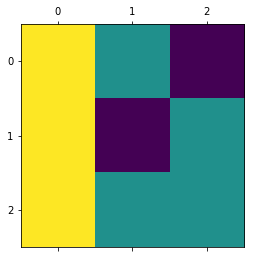

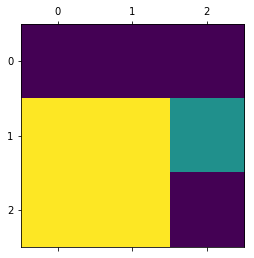

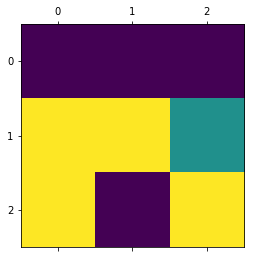

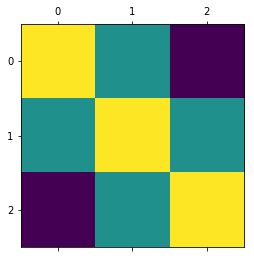

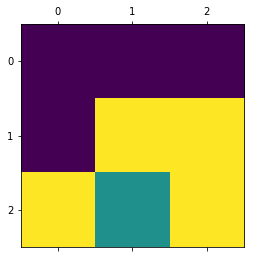

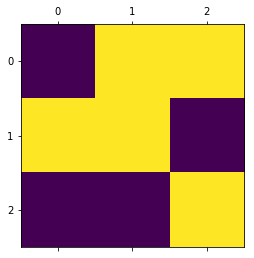

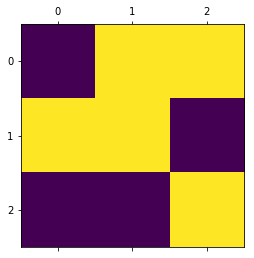

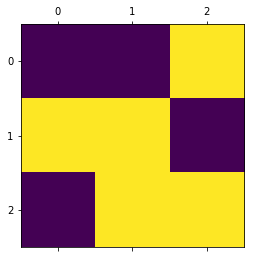

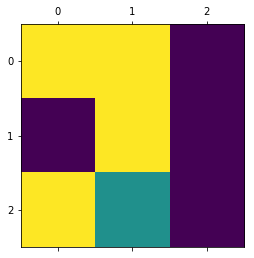

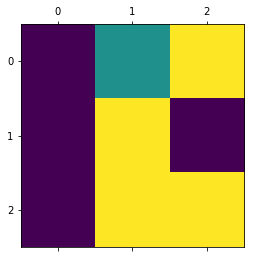

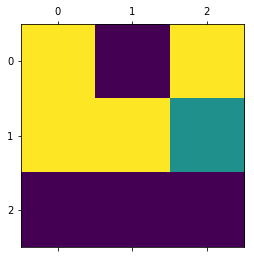

In [13]:
%%time

examples, states, labels, probs = trainer.train_player()
for g in examples[::10]:
    plt.matshow(g[-1][0][0].reshape(3, 3))